As the outcome of validation data are available, I'll refit the prep pipeline and models to make prediction.

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
import compose
%matplotlib inline


import sys
import os
import warnings
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline
from nzcompetition.plots import plot_train_pred, plot_pred_distribution

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from libdl.dl import dl

y_col = 'odor'
y_col_raw = 'TOM Odor PT Model X'
# for plotting
lim=[0, 3.5]

random_state=190624

# Data

In [2]:
X_train, y, X_val = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)
X_train = nzcompetition.drop_tom(X_train)
X_val = nzcompetition.drop_tom(X_val)

In [3]:
X_test = nzcompetition.get_test_data()

In [4]:
print(X_train.shape, y.shape, X_val.shape, X_test.shape)

(122, 108) (122,) (61, 108) (60, 108)


### Outcomes of validation set

Full validation set with outcomes are in file `validation`.

In [5]:
y_val = (
    dl.datasets.get(id='nz_kaggle')
    .files.get(id='validation')
    .as_df()
    .set_index(["Organism Code", "purifiedsample_sequoia_identifier"])
    [y_col_raw]
)

### Full training set

In [6]:
X = pd.concat([X_train, X_val])
X.shape

(183, 108)

In [7]:
y = pd.concat([y, y_val])

# TTF07N_adaboost

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    prep_pipe = make_prep_pipeline(True, True, False, 0.7)
    X_prep = prep_pipe.fit_transform(X)
    X_test_prep = prep_pipe.transform(X_test)

In [62]:
ada_reg = joblib.load('../models/submission/odor_TTF07N_adaboost.pkl')

In [63]:
ada_reg.fit(X_prep, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=6,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.8659769179092902, loss='linear',
                  n_estimato

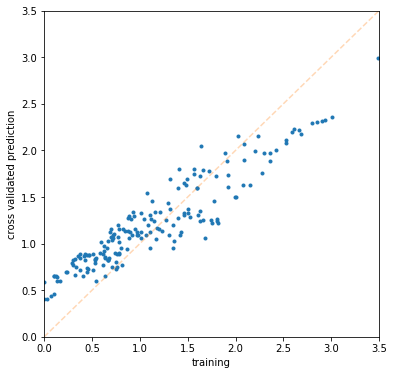

In [64]:
plot_train_pred(y, ada_reg.predict(X_prep), lim)

In [65]:
mean_squared_error(y, ada_reg.predict(X_prep))

0.11400568398599549

In [66]:
cvs = cross_val_score(ada_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

[-0.32636545 -0.35736254 -0.4457603  -0.277584   -0.47922497] -0.37725944953759366


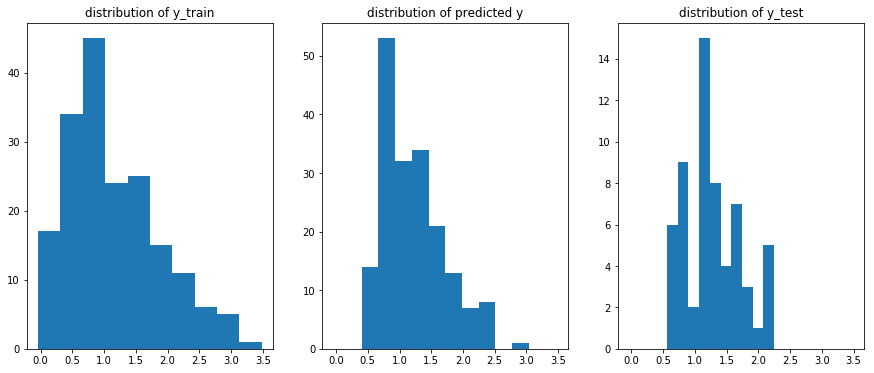

In [37]:
plot_pred_distribution(y, ada_reg.predict(X_prep), ada_reg.predict(X_test_prep))

In [15]:
pd.DataFrame(
    ada_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/odor_TTF07N_adaboost_refit_with_val.csv')

In [16]:
joblib.dump(ada_reg, '../models/submission/odor_TTF07N_adaboost_refit_with_val.pkl')

['../models/submission/odor_TTF07N_adaboost_refit_with_val.pkl']

This prediction got an MSE `0.2391` in test set. Compared with `0.116` in training, we might consider regularize the model more.

In [94]:
ada_reg.set_params(
    n_estimators=40, 
    base_estimator__random_state=random_state, 
    base_estimator__max_depth=4, 
    base_estimator__min_samples_leaf=8, 
#    base_estimator__max_leaf_nodes=20
)
cvs = cross_val_score(ada_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

[-0.25605044 -0.38788863 -0.43743755 -0.27345559 -0.44275409] -0.3595172595246544


In [95]:
ada_reg.fit(X_prep, y)
mean_squared_error(y, ada_reg.predict(X_prep))

0.08582470831768353

In [96]:
pd.DataFrame(
    ada_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/odor_TTF07N_adaboost_refit2.csv')

In [97]:
joblib.dump(ada_reg, '../models/submission/odor_TTF07N_adaboost_refit2.pkl')

['../models/submission/odor_TTF07N_adaboost_refit2.pkl']

This prediction got an MSE `0.2101` in test set.

### XGBoost

In [1]:
import xgboost

from scipy.stats import (
    randint, 
    expon, 
    reciprocal, 
    uniform, 
    norm,
)

In [ ]:
param_dist = dict(
    max_depth=[3,4,5], 
    learning_rate = uniform(0.05, 0.1), 
    subsample=uniform(0.3, 0.7), 
    reg_alpha=uniform(0, 1), 
    reg_lambda=uniform(0, 1), 
)

xgb_search = RandomizedSearchCV(
    xgboost.XGBRegressor(objective='reg:squarederror', random_state=random_state), 
    param_distributions=param_dist, 
    n_iter=10000, 
    scoring='neg_mean_squared_error', 
    n_jobs=15, 
    cv=5, 
    verbose=0, 
    iid=False, 
)

In [120]:
cvs = cross_val_score(
    xgb_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[-0.31371441 -0.37617157 -0.5495764  -0.25539771 -0.45493301] -0.3899586202897032


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# TTF10098_randfor

In [109]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    prep_pipe = Pipeline([
        ('prep', make_prep_pipeline(True, True, False, 1.0)), 
        ('pca', PCA(0.98))
    ])
    X_prep = prep_pipe.fit_transform(X)
    X_test_prep = prep_pipe.transform(X_test)

In [17]:
randfor_reg = joblib.load('../models/submission/odor_TTF10098_randfor.pkl')

In [19]:
randfor_reg.fit(X_prep, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

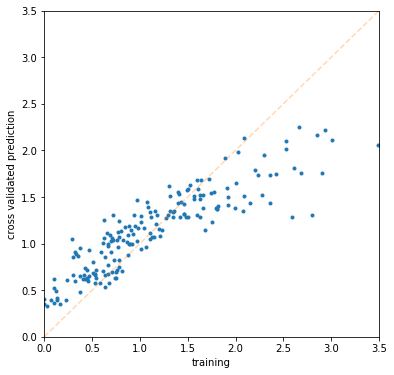

In [20]:
plot_train_pred(y, randfor_reg.predict(X_prep), lim)

In [21]:
mean_squared_error(y, randfor_reg.predict(X_prep))

0.15204219488257484

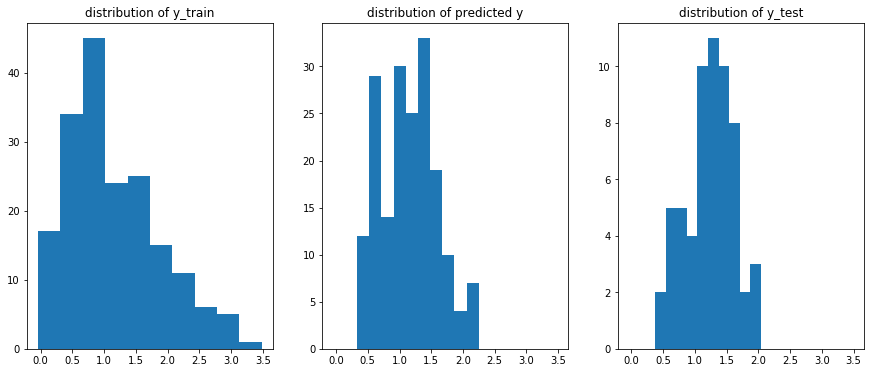

In [22]:
plot_pred_distribution(y, randfor_reg.predict(X_prep), randfor_reg.predict(X_test_prep))

In [23]:
pd.DataFrame(
    randfor_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/odor_TTF10098_randfor_refit_with_val.csv')

In [24]:
joblib.dump(ada_reg, '../models/submission/odor_TTF10098_randfor_refit_with_val.pkl')

['../models/submission/odor_TTF10098_randfor_refit_with_val.pkl']

This prediction got an MSE `0.2604` in test set.